<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr2/blob/Borisov-Vasily-folder/Borisov%20Vasily/Profpatolog_%2B_Hazard_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split 
import requests 
from urllib.parse import urlencode 
 
# читаем список нужных нам полей с ЯД (файл эксель)
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/i/QWJez3NW1JGGcg' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
download_response = requests.get(download_url) 
df_polei = pd.read_excel(download_url) 

base_dir = '/content/PrPt'
gdown.download('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/датасет%20профпатолог%20часть.xlsx', None, quiet=True)
data = pd.read_excel('датасет%20профпатолог%20часть.xlsx')

In [2]:
data=data.replace('ГоденСКоррекциейЗрения','ОграниченноГоден')
data=data.replace('ГоденБезРаботНаВысотах','ОграниченноГоден')
data=data.replace('НуждаетсяВДообследованииИЛечении','ВременноНегоден')
# arrZakMK = ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']
arrZakMK = ['Годен', 'ВременноНегоден', 'ОграниченноГоден']
columnsWithLists = ['ВредныеФакторы']
data.shape


(1982, 4587)

In [3]:
data500  = data.copy() 
nmp=df_polei['POLE'].tolist()
print(nmp)

for (columnName, columnData) in data500.items():
  if (str(columnName) in nmp)==False:
    data500.pop(columnName)

data500 = data500[data500.ЗаключениеМК.isin(arrZakMK) == True ]
print(data500.shape)
  

['КлиентПолПредставление', 'Профессия', 'ЗаключениеМК', 'ВредныеФакторы', 'Рентгенология1_Заключение_ЗначениеПредставление', 'ПсихиатрияНаркология1_МКБ101', 'ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление', 'Офтальмология1_МКБ101', 'Офтальмология1_ГоденНегоден_ЗначениеПредставление', 'Оториноларингология1_МКБ101', 'Оториноларингология1_ГоденНегоден_ЗначениеПредставление', 'ХирургНеИсп1_МКБ101', 'ХирургНеИсп1_ГоденНегоден_ЗначениеПредставление', 'Гинекология1_МКБ101', 'Гинекология1_ГоденНегоден_ЗначениеПредставление', 'Стоматология1_МКБ101', 'Стоматология1_ГоденНегоден_ЗначениеПредставление', 'Терапия1_ГоденНегоден_ЗначениеПредставление', 'Дерматовенерология1_МКБ101', 'Дерматовенерология1_ГоденНегоден_ЗначениеПредставление', 'Рентгенология1_МКБ101', 'Рентгенология1_ПрофнепригодностьВременная1', 'Неврология1_МКБ101', 'Неврология1_ПрофнепригодностьВременная1', 'Неврология1_ГоденНегоден_ЗначениеПредставление', 'Терапия1_МКБ101', 'Хирургия1_МКБ101', 'Хирургия1_ГоденНегоден_Значени

In [4]:
razdelitel = ","
ListOfColumnNames = []
ListOfColumnValues = []
ListOfColumnNames_Lists = []
for (columnName, columnData) in data500.items():
  ListOfColumnNames.append(columnName)
  if columnName in columnsWithLists:
    ListOfColumnValues.append(list(set(razdelitel.join(data500['ВредныеФакторы'].tolist()).splitlines()[0].split(','))))
  else:  
    ListOfColumnValues.append(list(data500[columnName].dropna().unique().flatten()))

In [5]:
def get_vector(row, columnNumber):
  i = 0
  vector = []
  vectorLen = len(ListOfColumnValues[columnNumber])
  if vectorLen < 25:
    while i < vectorLen:
      if (ListOfColumnValues[columnNumber][i] == row[columnNumber]):
        Null_or_One = 1
      else:
        Null_or_One = 0
      vector = np.hstack([vector, Null_or_One])
      i+=1
  return vector

def get_vector_from_list(row, columnNumber):
  i = 0
  vector = []
  vectorLen = len(ListOfColumnValues[columnNumber])
  rowToList = ((row[columnNumber].split(',')))
  while i < vectorLen:
    if (ListOfColumnValues[columnNumber][i] in rowToList):
      Null_or_One = 1
    else:
      Null_or_One = 0
    vector = np.hstack([vector, Null_or_One])
    i+=1
  return vector

def extract_row_data(row):
  x_data = []
  y_data = []
  

  for columnName in ListOfColumnNames:
    columnNumber = ListOfColumnNames.index(columnName)
    if columnName == 'ЗаключениеМК':
      y_data = np.hstack([y_data, get_vector(row, columnNumber)])
    elif columnName in columnsWithLists:
      x_data = np.hstack([x_data, get_vector_from_list(row, columnNumber)])
    else:
      x_data = np.hstack([x_data, get_vector(row, columnNumber)])
  return x_data, y_data



def construct_train_data(row_list):
    x_data = []
    y_data = []
    for row in row_list:
        x, y = extract_row_data(row)
        x_data.append(x)
        y_data.append(y)
    return np.array(x_data), np.array(y_data)


x_data500, y_data500 = construct_train_data(data500.values)

In [6]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
import matplotlib.pyplot as plt 
from PIL import Image 
%matplotlib inline 

# Разбиение наборов на общую и тестовую выборки
x_all, x_test, y_all, y_test = train_test_split(x_data500, 
                                                y_data500, 
                                                test_size=0.1, 
                                                shuffle=True, 
                                                random_state = 6)

# Разбиение общей выборки на обучающую и проверочную 
x_train, x_val, y_train, y_val = train_test_split(x_all, 
                                                  y_all, 
                                                  test_size=0.1, 
                                                  shuffle=True, 
                                                  random_state = 6)


model = Sequential()
model.add(Dense(800, input_dim=x_train.shape[1], activation='relu')) 
model.add(Dropout(0.1, noise_shape=None, seed=None))
model.add(Dense(400, activation='relu')) 
model.add(Dense(3, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.1)



Epoch 1/50
9/9 [==============================] - 6s 30ms/step - loss: 0.5541 - accuracy: 0.8618 - val_loss: 0.3293 - val_accuracy: 0.9219
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.3387 - accuracy: 0.9046 - val_loss: 0.2704 - val_accuracy: 0.9219
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.2812 - accuracy: 0.9046 - val_loss: 0.2281 - val_accuracy: 0.9297
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2270 - accuracy: 0.9099 - val_loss: 0.2071 - val_accuracy: 0.9297
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1930 - accuracy: 0.9169 - val_loss: 0.1952 - val_accuracy: 0.9297
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.1627 - accuracy: 0.9309 - val_loss: 0.2200 - val_accuracy: 0.9297
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.1425 - accuracy: 0.9361 - val_loss: 0.1920 - val_accuracy: 0.9375
Epoch 8/50
9/9 [=================

5/5 [==============================] - 0s 4ms/step - loss: 0.4832 - accuracy: 0.9085


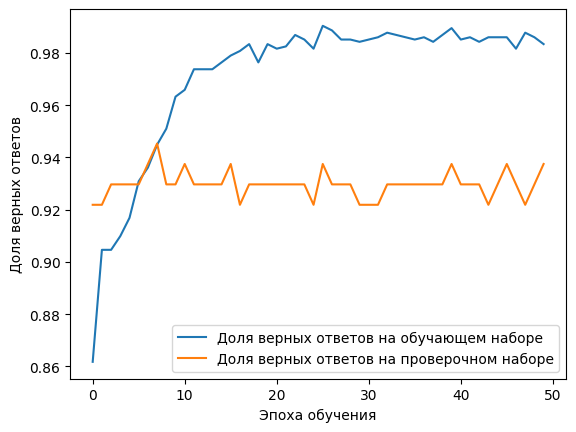

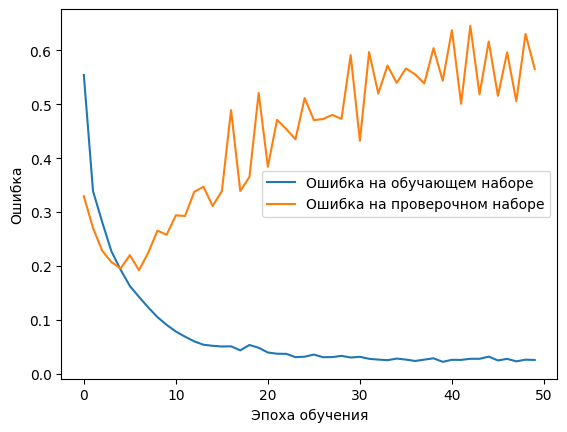

In [7]:
scores = model.evaluate(x_test, 
                        y_test, 
                        verbose=1
                        )
scores2 = model.evaluate(x_val, 
                        y_val, 
                        verbose=1
                        )
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()


plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')

plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()